# Title: Compute per‑tile total biomass from AGLWBD (30 m) raster
#
This notebook:
1. Loads the 30 m biomass raster and the plain tiles GeoJSON (1 km tiles with geometry).
2. Reprojects tiles to the raster CRS (so areas/pixel sizes are correct).
3. Computes zonal stats (sum, mean, count) per tile using rasterstats.
4. Interprets units (choose whether raster values are Mg/pixel or Mg/ha).
5. Produces quick static and interactive visualizations and writes a GeoJSON/CSV.

In [9]:
# CODE CELL: install & imports (run once)
import sys
# Uncomment to install missing packages (run in notebook once)
# !{sys.executable} -m pip install rasterio geopandas rasterstats rioxarray folium seaborn matplotlib --quiet

import warnings
warnings.filterwarnings("ignore", message="Iteration over dataset of unknown size")
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
from shapely.geometry import mapping
import rioxarray as rxr
from rasterio.warp import Resampling
import pandas as pd


In [18]:
# CODE CELL: configure file paths
raster_path = "../data/aglwb.tif"         # <-- change to your raster
plain_tiles_path = "../data/lamwo_sentinel_composites/lamwo_grid.geojson"  # <-- your geojson with tile geometries (1km polygons)
tile_stats_path = "../data/Lamwo_Tile_Stats_EE.csv"  # <-- your csv with tile stats (e.g. cloud cover)
out_geojson = "../data/Lamwo_Tile_Stats_EE_biomass.geojson"
out_csv = "../data/Lamwo_Tile_Stats_EE_biomass.csv"

In [3]:
# CODE CELL: inspect and load data
# Load tiles (GeoJSON)
tiles = gpd.read_file(plain_tiles_path)
print("Tiles CRS:", tiles.crs)
print("Tiles rows:", len(tiles))
display(tiles.head())

# Open raster and show basic metadata
with rasterio.open(raster_path) as src:
    print("Raster CRS:", src.crs)
    print("Raster transform:", src.transform)
    print("Raster dtype:", src.dtypes[0])
    print("Raster nodata:", src.nodata)
    pixel_width, pixel_height = src.res
    pix_area_m2 = abs(pixel_width * pixel_height)
    print("Pixel size (m):", pixel_width, pixel_height, "=> pixel area (m^2):", pix_area_m2)

Tiles CRS: EPSG:4326
Tiles rows: 5657


geometry
0  POLYGON ((32.20445 3.49577, 32.20446 3.48679, ...
1  POLYGON ((32.20445 3.50482, 32.20445 3.49577, ...
2  POLYGON ((32.20445 3.50482, 32.20111 3.50482, ...
3  MULTIPOLYGON (((32.20443 3.52291, 32.20443 3.5...
4  POLYGON ((32.20443 3.52291, 32.20350 3.52291, ...

Raster CRS: EPSG:4326
Raster transform: | 0.00, 0.00, 32.20|
| 0.00,-0.00, 3.89|
| 0.00, 0.00, 1.00|
Raster dtype: float32
Raster nodata: None
Pixel size (m): 0.00025 0.00025 => pixel area (m^2): 6.25e-08


Reproject tiles to raster CRS for correct area/pixel alignment before zonal stats.

In [4]:
# CODE CELL: reproject tiles + raster to metric CRS
# Open WGS84 raster (EPSG:4326)
r = rxr.open_rasterio(raster_path)
# reproject to UTM 36N
r_utm = r.rio.reproject(
    "EPSG:32636",
    resampling=Resampling.nearest
)
r_utm.rio.to_raster("in_utm_32636.tif")
#convert raster and tiles to metric CRS
tiles_r    = tiles.to_crs(32636)       # UTM 36N, meters


# compute tile area in m^2 (CRS must be projected)
tiles_r["area_m2"] = tiles_r.geometry.area
tiles_r["area_ha"] = tiles_r["area_m2"] / 10000.0
display(tiles_r[["area_m2", "area_ha"]].describe())

/Users/Imran/miniconda3/envs/geospatial/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


area_m2      area_ha
count  5.657000e+03  5657.000000
mean   9.615587e+05    96.155866
std    1.625242e+05    16.252418
min    5.218976e+00     0.000522
25%    1.000000e+06   100.000000
50%    1.000000e+06   100.000000
75%    1.000000e+06   100.000000
max    1.000000e+06   100.000000

Compute zonal stats. We get sum, mean, and count per tile.
Note: interpretation depends on raster units:
  - If raster values = Mg PER PIXEL => zonal_stats(sum) gives total Mg per tile.
  - If raster values = Mg/ha (density) => tile_total_Mg = mean * tile_area_ha (or sum_pixel_values * pixel_area_ha).

In [5]:
# CODE CELL: run zonal_stats and attach results
with rasterio.open("in_utm_32636.tif") as src:
    nodata = src.nodata

zs = zonal_stats(
    tiles_r.geometry,
    "in_utm_32636.tif",
    stats=["sum", "mean", "count"],
    nodata=nodata,
    all_touched=False,   # set True to include any touched pixels (more inclusive)
    geojson_out=False,
)

# attach results in correct order
tiles_r["r_sum"] = [z.get("sum", np.nan) for z in zs]
tiles_r["r_mean"] = [z.get("mean", np.nan) for z in zs]
tiles_r["r_count"] = [z.get("count", 0) for z in zs]

display(tiles_r[["r_sum", "r_mean", "r_count"]].head())

r_sum    r_mean  r_count
0  1546.604736  2.962844      522
1  2166.687744  3.135583      691
2   439.708069  2.484226      177
3   107.045807  2.378796       45
4   336.109985  3.734555       90

Choose how to interpret the raster values:
Set raster_unit = "Mg_per_pixel"  OR  "Mg_per_ha"
If you are unsure, check dataset docs or inspect a small area manually.

In [6]:
# CODE CELL: convert to per-tile total biomass based on unit
raster_unit = "Mg_per_pixel"   # <-- choose "Mg_per_pixel" or "Mg_per_ha"

if raster_unit == "Mg_per_pixel":
    # zonal_stats.sum is already sum of pixel values => total Mg per tile
    tiles_r["tile_total_Mg"] = tiles_r["r_sum"]
elif raster_unit == "Mg_per_ha":
    # pixel values are density (Mg/ha): tile_total = mean_density * tile_area_ha
    tiles_r["tile_total_Mg"] = tiles_r["r_mean"] * tiles_r["area_ha"]
else:
    raise ValueError("Set raster_unit to 'Mg_per_pixel' or 'Mg_per_ha'")

# Basic QA
print("Tiles with NaN totals:", tiles_r["tile_total_Mg"].isna().sum())
display(tiles_r[["tile_total_Mg"]].describe())

Tiles with NaN totals: 7


tile_total_Mg
count    5650.000000
mean     3543.429800
std      2078.213594
min         0.000000
25%      2446.498840
50%      3055.315796
75%      3805.678101
max     23974.714844

Quick static plots (matplotlib / geopandas)

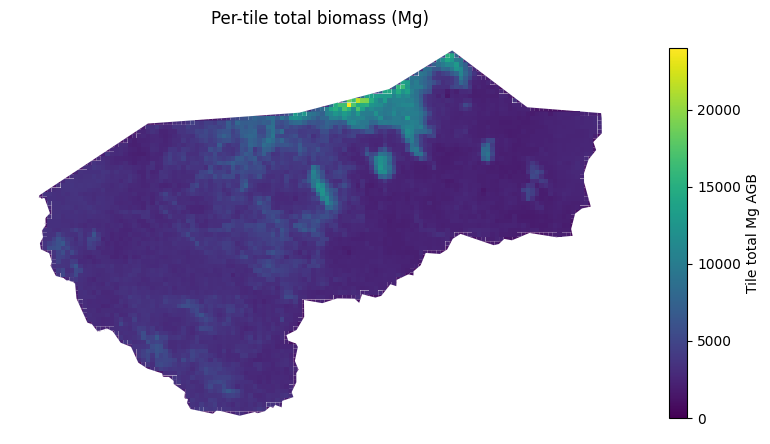

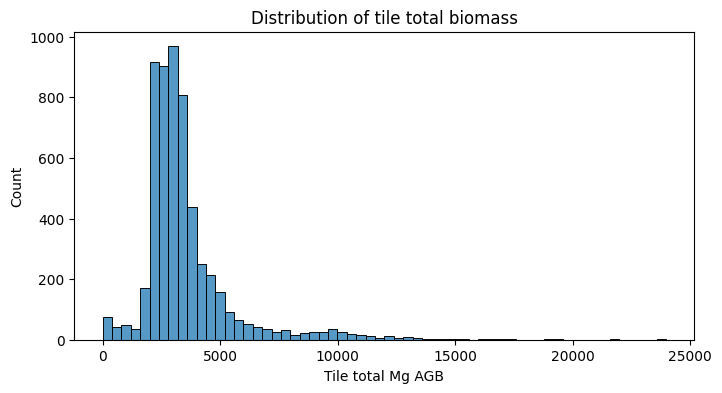

In [7]:
# CODE CELL: choropleth (static)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
tiles_r.plot(column="tile_total_Mg", ax=ax, cmap="viridis", legend=True,
             legend_kwds={"label": "Tile total Mg AGB", "shrink": 0.6})
ax.set_title("Per-tile total biomass (Mg)")
ax.set_axis_off()
plt.show()

# histogram
plt.figure(figsize=(8, 4))
sns.histplot(tiles_r["tile_total_Mg"].dropna(), bins=60, kde=False)
plt.xlabel("Tile total Mg AGB")
plt.title("Distribution of tile total biomass")
plt.show()

Interactive map with folium (convert to EPSG:4326 for leaflet)

In [8]:
# CODE CELL: folium choropleth (interactive)
tiles_wgs = tiles_r.to_crs("EPSG:4326")
m = folium.Map(location=[tiles_wgs.geometry.centroid.y.mean(), tiles_wgs.geometry.centroid.x.mean()], zoom_start=10)
# prepare geojson
geojson = tiles_wgs.to_json()

# Use a linear colormap
import branca.colormap as cm
vmin = tiles_wgs["tile_total_Mg"].min()
vmax = tiles_wgs["tile_total_Mg"].quantile(0.99)  # cap color at 99th pct to avoid extreme skew
colormap = cm.linear.YlGn_09.scale(vmin, vmax)
colormap.caption = "Tile total Mg AGB"
colormap.add_to(m)

folium.GeoJson(
    geojson,
    name="tiles",
    style_function=lambda feat: {
        "fillColor": colormap(feat["properties"].get("tile_total_Mg") or 0),
        "color": "#333333",
        "weight": 0.3,
        "fillOpacity": 0.8,
    },
    tooltip=folium.GeoJsonTooltip(fields=["tile_total_Mg"], labels=True),
).add_to(m)
# add plain tiles (tiles) to map
folium.GeoJson(
    tiles.to_json(),
    name="plain_tiles",
    style_function=lambda feat: {
        "fillColor": "#ffffff",
        "color": "#333333",
        "weight": 0.3,
        "fillOpacity": 0.8,
    },
).add_to(m)

#layer toggling on
folium.LayerControl().add_to(m)
m

/var/folders/8h/x4dy974d74qbv947r78v2l_m0000gn/T/ipykernel_15397/1064216052.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[tiles_wgs.geometry.centroid.y.mean(), tiles_wgs.geometry.centroid.x.mean()], zoom_start=10)


Save results: GeoJSON (with geometries) and CSV (attributes only)

In [14]:
#read and display tile stats csv
tile_stats = pd.read_csv(tile_stats_path)
tile_stats.head()

ndvi_mean  ndvi_med  ndvi_std   evi_med   elev_mean  slope_mean  \
0  -0.507665 -0.662579  0.205291  1.927150  661.247028    3.468728   
1  -0.517304 -0.628960  0.206539  1.978630  660.667390    3.641268   
2  -0.410299 -0.587629  0.164471  1.775164  652.781977    5.080677   
3  -0.527696 -0.626940  0.193225  1.772409  653.080518    3.040932   
4  -0.632031 -0.720702  0.197612  2.258251  655.343124    4.595804   

     par_mean  rain_total_mm  rain_mean_mm_day  cloud_free_days  bldg_count  \
0  189.643417       9.334060          3.269485               29         0.0   
1  188.999216      18.509185          3.241650               29         0.0   
2  182.854523       0.000000               NaN               29         0.0   
3  182.854523       0.000000               NaN               29         0.0   
4  182.854523       0.000000               NaN               29         0.0   

   bldg_area  bldg_h_max  system:index  
0        0.0         0.0             0  
1        0.0         0.0             1  
2        0.0         0.0             2  
3        0.0         0.0             3  
4        0.0         0.0             4

In [15]:
tiles_wgs.head()

geometry        area_m2  \
0  POLYGON ((32.20445 3.49577, 32.20446 3.48679, ...  403986.349446   
1  POLYGON ((32.20445 3.50482, 32.20445 3.49577, ...  530893.253186   
2  POLYGON ((32.20445 3.50482, 32.20111 3.50482, ...  131697.223294   
3  MULTIPOLYGON (((32.20443 3.52291, 32.20443 3.5...   34775.414353   
4  POLYGON ((32.20443 3.52291, 32.20350 3.52291, ...   68720.493973   

     area_ha        r_sum    r_mean  r_count  tile_total_Mg  
0  40.398635  1546.604736  2.962844      522    1546.604736  
1  53.089325  2166.687744  3.135583      691    2166.687744  
2  13.169722   439.708069  2.484226      177     439.708069  
3   3.477541   107.045807  2.378796       45     107.045807  
4   6.872049   336.109985  3.734555       90     336.109985

In [17]:
# merge area_m2 and tile_total_Mg into tile_stats on index
tile_stats_biomass = tile_stats.merge(tiles_wgs[["geometry", "area_m2", "tile_total_Mg"]], left_index=True, right_index=True, how="left").drop(columns=["system:index"])

tile_stats_biomass.head()

ndvi_mean  ndvi_med  ndvi_std   evi_med   elev_mean  slope_mean  \
0  -0.507665 -0.662579  0.205291  1.927150  661.247028    3.468728   
1  -0.517304 -0.628960  0.206539  1.978630  660.667390    3.641268   
2  -0.410299 -0.587629  0.164471  1.775164  652.781977    5.080677   
3  -0.527696 -0.626940  0.193225  1.772409  653.080518    3.040932   
4  -0.632031 -0.720702  0.197612  2.258251  655.343124    4.595804   

     par_mean  rain_total_mm  rain_mean_mm_day  cloud_free_days  bldg_count  \
0  189.643417       9.334060          3.269485               29         0.0   
1  188.999216      18.509185          3.241650               29         0.0   
2  182.854523       0.000000               NaN               29         0.0   
3  182.854523       0.000000               NaN               29         0.0   
4  182.854523       0.000000               NaN               29         0.0   

   bldg_area  bldg_h_max                                           geometry  \
0        0.0         0.0  POLYGON ((32.20445 3.49577, 32.20446 3.48679, ...   
1        0.0         0.0  POLYGON ((32.20445 3.50482, 32.20445 3.49577, ...   
2        0.0         0.0  POLYGON ((32.20445 3.50482, 32.20111 3.50482, ...   
3        0.0         0.0  MULTIPOLYGON (((32.20443 3.52291, 32.20443 3.5...   
4        0.0         0.0  POLYGON ((32.20443 3.52291, 32.20350 3.52291, ...   

         area_m2  tile_total_Mg  
0  403986.349446    1546.604736  
1  530893.253186    2166.687744  
2  131697.223294     439.708069  
3   34775.414353     107.045807  
4   68720.493973     336.109985

In [20]:
# CODE CELL: save outputs
#convert tile_stats_biomass to geodataframe
tile_stats_biomass_gdf = gpd.GeoDataFrame(tile_stats_biomass, geometry="geometry", crs=tiles_wgs.crs)
tile_stats_biomass_gdf.to_file(out_geojson, driver="GeoJSON")
tile_stats_biomass_gdf.drop(columns="geometry").to_csv(out_csv, index=False)
print("Saved:", out_geojson, out_csv)

Saved: ../data/Lamwo_Tile_Stats_EE_biomass.geojson ../data/Lamwo_Tile_Stats_EE_biomass.csv
